## Estimando Melhores Combinações de Jogadores Utilizando Bootstrap

No competitivo dos jogos do gênero Battle Royale a pontuação por kill tem muita relevância no desempenho final de um time nas partidas. Assim sendo, esse desempenho depende da performance individual dos jogadores, e consequentemente da combinação que a comissão técnica opta por escalar, uma vez que o competitivo da modalidade é coletiva, com 4 players podendo entrar por queda.

Portanto, a fase de criação da equipe antes dos jogos começarem é uma etapa essencial pra obter bons resultados no final da temporada, e na maioria das vezes não há tempo hábil para testar diferentes jogadores, e muito menos combinações entre eles com uma quantidade razoável de partidas. Logo, aplicar técnicas de bootstrap para estimar indicadores de desempenho tanto de combinações de jogadores que já jogaram juntos quanto de formações que ainda não jogaram, será bem útil para a comissão decidir quem agregará mais ao grupo. 

Deste modo, aplicaremos a técnica de bootstrap em dados coletados no fim do ano de 2022 em testes realizados na equipe XIS com intuito de estimar as melhores combinações de jogadores para contratações. Os dados foram extraidos de prints tirados pelos jogadores a cada final de partida e assim foi criado um banco de dados para ser trabalhado posteriormente. Como métrica de desempenho utilizaremos as kills individuais dos jogadores e assim agregaremos ao coletivo onde extraíremos a média de kills dos diferentes times formados em n simulações.

## Scripts

In [7]:
#Carregando Pacotes
require(dplyr)
require(tidyr)
require(bootstrap)
require(ggplot2)

#Carregando e Configurando Dados
setwd("C:/Users/pedro/Desktop/")
data = read.table("XIS_PLAYERS.txt",header = TRUE, sep = "\t")
str(data)

'data.frame':	448 obs. of  12 variables:
 $ PLAYER     : Factor w/ 13 levels "","ALVES","CAUE",..: 13 8 3 7 7 3 8 13 3 13 ...
 $ KILLS      : int  4 2 1 1 3 0 0 0 2 1 ...
 $ DEADS      : int  1 2 2 2 1 1 1 1 1 1 ...
 $ ASS        : int  0 0 0 1 1 2 0 1 1 0 ...
 $ DANO       : int  1146 608 1219 913 1304 14 151 146 868 757 ...
 $ DERRUBADOS : int  4 2 1 1 4 2 0 0 3 1 ...
 $ CURA       : int  410 89 70 148 301 173 32 261 161 189 ...
 $ SAVES      : int  0 0 1 0 1 0 0 0 2 0 ...
 $ USO.RETORNO: int  1 0 0 0 0 0 0 0 0 0 ...
 $ SURVIVE_M  : int  13 12 13 13 9 12 8 9 7 7 ...
 $ SURVIVE_S  : int  30 50 30 29 23 36 31 18 58 21 ...
 $ MATCH_ID   : int  1 1 1 1 2 2 2 2 3 3 ...


In [8]:
summary(data)

     PLAYER       KILLS            DEADS           ASS             DANO     
 GOABE  :82   Min.   : 0.000   Min.   :0.00   Min.   :0.000   Min.   :   0  
 CAUE   :73   1st Qu.: 0.000   1st Qu.:1.00   1st Qu.:0.000   1st Qu.: 400  
 ICE    :72   Median : 1.000   Median :1.00   Median :1.000   Median : 908  
 GLAUCO :69   Mean   : 1.881   Mean   :1.24   Mean   :1.343   Mean   :1060  
 HAK    :45   3rd Qu.: 3.000   3rd Qu.:2.00   3rd Qu.:2.000   3rd Qu.:1426  
 MOTOVEA:38   Max.   :10.000   Max.   :5.00   Max.   :9.000   Max.   :5743  
 (Other):69   NA's   :2        NA's   :2      NA's   :2       NA's   :2     
   DERRUBADOS          CURA             SAVES         USO.RETORNO    
 Min.   : 0.000   Min.   :   0.00   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 1.000   1st Qu.:  90.75   1st Qu.:0.0000   1st Qu.:0.0000  
 Median : 2.000   Median : 279.50   Median :0.0000   Median :0.0000  
 Mean   : 2.256   Mean   : 381.97   Mean   :0.3049   Mean   :0.3924  
 3rd Qu.: 3.000   3rd Qu.: 540.75 

In [14]:
#Criando função de bootstrap e simulando as formações de equipes
dados = na.omit(data[,c('PLAYER','KILLS')])

n = 30000
simulator = function(d,B){
  sim = data.frame()
  for(i in 1:B){
    players = unique(d$PLAYER)
  
    line = sort(sample(players,4))
    linekills = c(sample(d[d$PLAYER == line[1],]$KILLS,1),
                  sample(d[d$PLAYER == line[2],]$KILLS,1),
                  sample(d[d$PLAYER == line[3],]$KILLS,1),
                  sample(d[d$PLAYER == line[4],]$KILLS,1))
    id = rep(i,4)
    sim = rbind(sim,data.frame(line,linekills,id))
  }
  sim
}

set.seed(11721201)
fim = simulator(dados,n)
head(fim,8)

line,linekills,id
ALVES,2,1
GLAUCO,0,1
KENIDY,1,1
RZN,1,1
GOABE,6,2
KENIDY,0,2
MOTOVEA,0,2
RZN,0,2


In [16]:
#Tratando dados do dataframe de formações e criando visualização final
fim %>% group_by(line) %>%
  summarise(mean_kills = mean(linekills))

subset = fim %>% spread(key = line,value = linekills)

clines = c()
for(i in 1:nrow(subset)){
  a = sort(colnames(subset[i, colSums(is.na(subset[i,])) == 0])[-1])
  clines[i] = paste(a[1],a[2],a[3],a[4])
}

subset$clines = clines
soma = c()
for(i in 1:nrow(subset)){
  soma[i] = sum(subset[i,2:(ncol(subset)-1)],na.rm = TRUE)
}
subset$klines = soma

view = data.frame(subset %>% group_by(clines) %>% summarise(matchs = n(),mean_kills_line = mean(klines),sd_kills_line = sd(klines)) %>% arrange(desc(mean_kills_line)))

view$cv = (view$sd_kills_line/view$mean_kills_line)*100

line,mean_kills
ALVES,1.0041663
CAUE,1.8203071
GELO,1.3458692
GLAUCO,2.6377551
GOABE,1.7465072
GUSTAXL,1.4548736
HAK,1.7132235
ICE,1.9824103
KENIDY,0.6694822
MOTOVEA,2.5100658


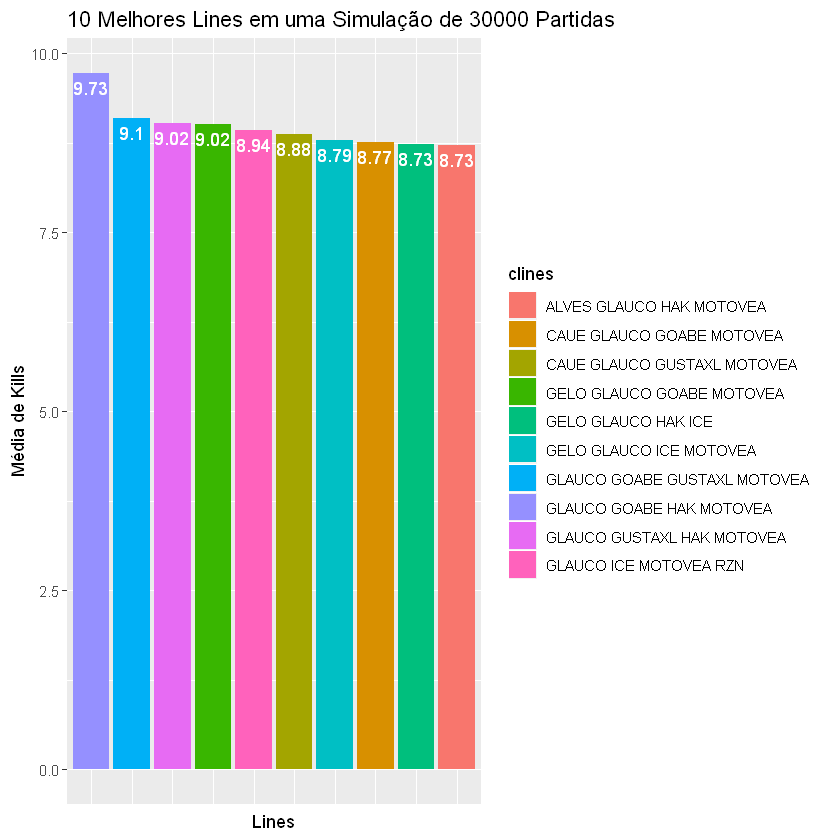

In [68]:
ggplot(data = top_n(view,10,mean_kills_line), mapping = aes(y = mean_kills_line, x = reorder(clines,-mean_kills_line), fill = clines))+
  geom_col()+
  geom_text(aes(label = round(mean_kills_line,2)),hjust = 'center',col = 'white',vjust = +1.5)+
  xlab('Lines')+
  ylab('Média de Kills')+
  ggtitle('10 Melhores Lines em uma Simulação de 30000 Partidas')+
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

## Conclusões Finais

Portanto, a partir do método bootstrap podemos concluir que a melhor em relação a média de kills é a composta pelos jogadores GLAUCO, GOABE, HAK e MOTOVEA. E assim, conseguiriamos direcionar a comissão técnica para contratar esses jogadores para a equipe principal, além da possibilidade de incluir mais 1 ou 2 player pra compor o elenco, escolhendo os 2 que juntos aos demais estariam entre as melhores lines formadas a partir do critério, que nesse caso seriam o GUSTAXL e GELO. Poderíamos também criar novas métricar a partir do conjunto de dados com finalidade de visualizar quais seriam as melhores lines compostas por elas e assim ter mais ferramentas pra tomada de decisão, além também de poder granularizar essa análise para diferentes situações impostas pelo jogo, como :
- Melhores Lines por Mapa
- Melhores Lines por Estilo de Jogo
- Melhores Lines por Estratégia